In [1]:
import json
from utils import Events

participants_that_changed_settings = Events.select().where(Events.event.startswith("SET_"))

# read participants.json
with open("participants.json", "r") as f:
    participants_metadata = json.load(f)

participants_to_analyze = set()

for participant in participants_that_changed_settings:
  if participant in participants_to_analyze:
    continue

  if participants_metadata.get(str(participant.participant_id)) is not None and participants_metadata.get(str(participant.participant_id))['split'] == 1:
     participants_to_analyze.add(participant.participant_id)

print("Participants to analyze: {}".format((participants_to_analyze)))

Participants to analyze: {1, 2, 6, 7}


Now that we know which participants changed the settings in the Obvious Problem experiment, we can plot their changes over time.

In [2]:
for participant in participants_to_analyze:
  print("Participant: {}".format(participant))
  events = Events.select().where(Events.participant_id == participant).order_by(Events.time.asc()).where(Events.event.startswith("SET_"))
  for event in events:
    print("  {} {}, {} -> {}".format(event.time, event.event, event.old_value, event.new_value))

Participant: 1
  1702640142752 SET_TYPOGRAPHY_FONTWEIGHT, 100 -> 400
  1702640143651 SET_TYPOGRAPHY_FONTWEIGHT, 400 -> 100
  1702640144677 SET_TYPOGRAPHY_FONTSIZE, 14 -> 18
  1702640145492 SET_TYPOGRAPHY_FONTSIZE, 18 -> 14
  1702640147396 SET_TYPOGRAPHY_MARGINSIZE, small -> small
  1702640148099 SET_TYPOGRAPHY_MARGINSIZE, small -> large
  1702640149020 SET_TYPOGRAPHY_MARGINSIZE, large -> small
  1702640152412 SET_THEME, dark -> sepia
  1702640153715 SET_THEME, sepia -> light
  1702640154805 SET_THEME, light -> dark
Participant: 2
  1702547458042 SET_THEME, light -> dark
Participant: 6
  1702641344212 SET_TYPOGRAPHY_MARGINSIZE, large -> small
  1702641345896 SET_TYPOGRAPHY_MARGINSIZE, small -> large
  1702641346385 SET_TYPOGRAPHY_MARGINSIZE, large -> small
  1702641353900 SET_TYPOGRAPHY_FONTWEIGHT, 100 -> 400
  1702641357660 SET_TYPOGRAPHY_FONTSIZE, 24 -> 18
  1702641359400 SET_TYPOGRAPHY_FONTSIZE, 18 -> 24
  1702641360385 SET_TYPOGRAPHY_FONTSIZE, 24 -> 18
  1702641360952 SET_TYPOGRAPHY

In [3]:
# define colors for each participant 1-8
from utils import is_participant_data_low_resolution


colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

def plot_changes(participants_to_analyze, event_name, event_label, y_ticks=None, convert_int=False):
  import matplotlib.pyplot as plt

  fig, ax = plt.subplots(figsize=(9, 6))

  for participant in participants_to_analyze:
    events = Events.select().where(Events.participant_id == participant).order_by(Events.time.asc()).where(Events.event == event_name)
    if len(events) == 0:
      continue

    # get the first OPEN_BOOK event before the first SET_TYPOGRAPHY_FONTSIZE event
    open_book_event = Events.select().where(Events.participant_id == participant).order_by(Events.time.desc()).where(Events.event == "OPEN_BOOK").where(Events.time < events[0].time).get()

    x = [event.time for event in events]
    x.insert(0, open_book_event.time)

    # normalize x to start at 0
    low_res = is_participant_data_low_resolution(str(participant))
    if low_res:
      x = [
          (t - min(x)) for t in x
      ]
    else:
      x = [
            (t - min(x)) / 1000 for t in x
        ]
    y = [event.new_value for event in events]
    y.insert(0, events[0].old_value)
    if convert_int:
      y = [int(v) for v in y]

    ax.plot(x, y, label="Participant {}".format(participant), color=colors[participant - 1])
    ax.scatter(x, y, color=colors[participant - 1])

  ax.set(xlabel='time (s)', ylabel=event_label,
       title=f"{event_label} over time")
  if y_ticks is not None:
    ax.set_yticks(y_ticks)

  ax.grid()
  ax.legend()

  fig.autofmt_xdate()

  plt.show()

Font size changes over time

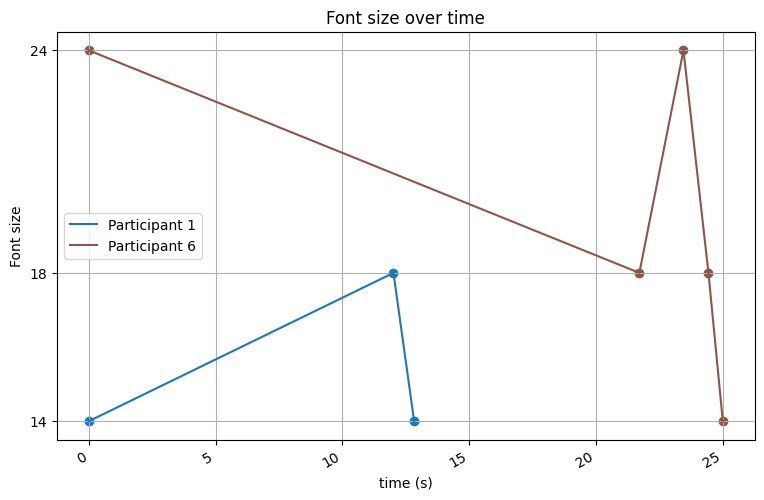

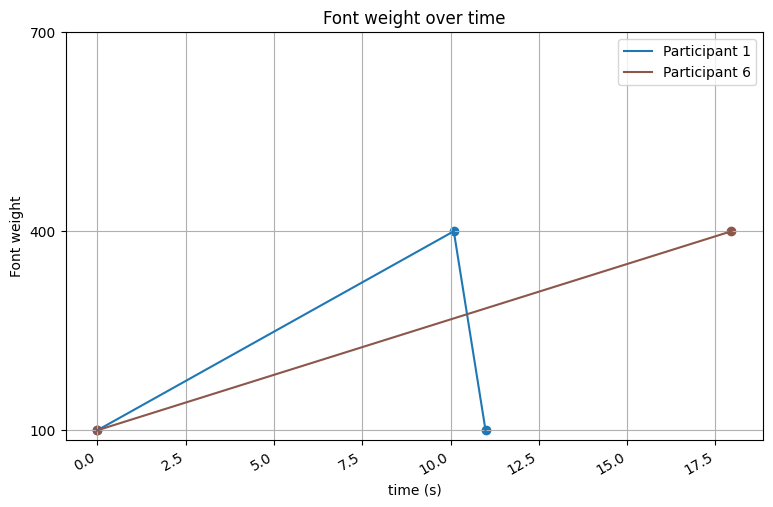

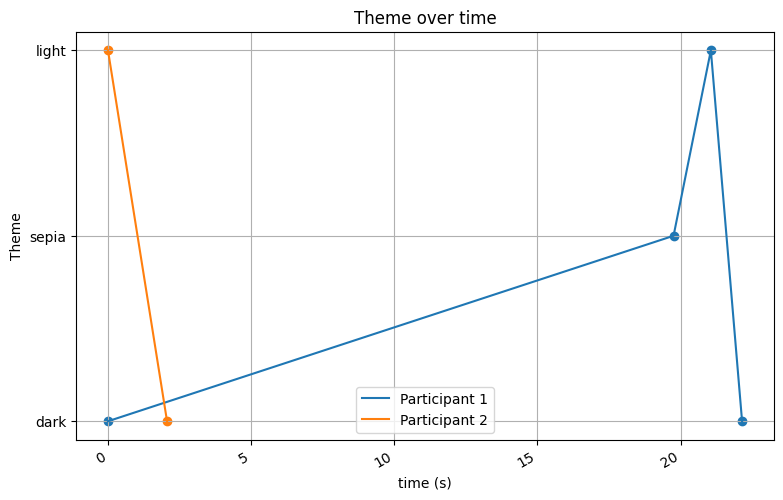

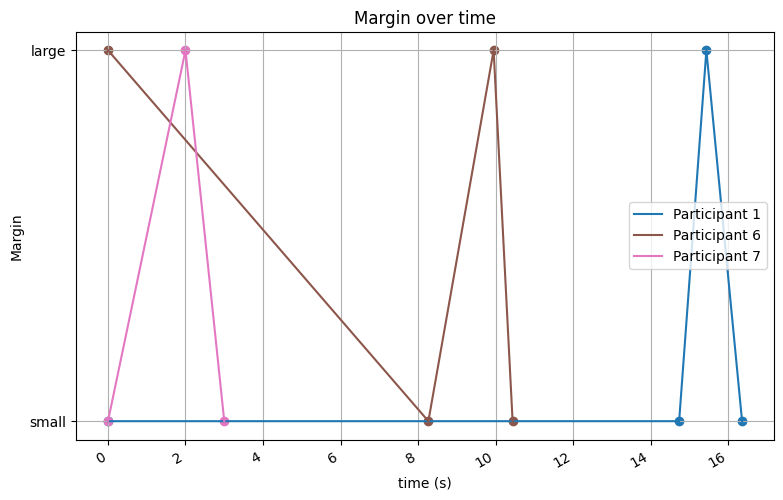

In [4]:
plot_changes(participants_to_analyze, "SET_TYPOGRAPHY_FONTSIZE", "Font size", y_ticks=[14, 18, 24], convert_int=True)
plot_changes(participants_to_analyze, "SET_TYPOGRAPHY_FONTWEIGHT", "Font weight", y_ticks=[100, 400, 700], convert_int=True)
plot_changes(participants_to_analyze, "SET_THEME", "Theme", y_ticks=['light', 'sepia', 'dark'])
plot_changes(participants_to_analyze, "SET_TYPOGRAPHY_MARGINSIZE", "Margin", y_ticks=['small', 'large'])

